In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mping
import numpy as np
import cv2
import glob
import pickle
import os
import json
from tqdm import tqdm

In [2]:
def read_train_data(train_path='./benchmark_velocity_train/clips/'):
    train_dirs = os.listdir(train_path)
    train_dirs = [i for i in train_dirs if i != '.DS_Store' and i[0]!='.']
    annnotations = []
    imgs = []
    for i in tqdm(train_dirs):
        with open(train_path+'1/annotation.json','r',encoding='utf8' )as f:
            annnotations.append(json.load(f))
        imgs.append(cv2.imread(train_path+i+"/imgs/040.jpg"))
    return imgs, annnotations

In [3]:
imgs, annnotations = read_train_data()

100%|██████████| 1074/1074 [00:16<00:00, 65.28it/s]


In [4]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return binary_output
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output
def hls_channels(img,c,thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if c =='s':
        channel=hls[:,:,2]
    else:
        channel=hls[:,:,1]
    binary_output = np.zeros_like(channel)
    binary_output[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    return binary_output

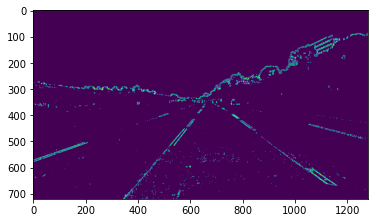

In [5]:
plt.imshow(abs_sobel_thresh(imgs[2],orient='x',thresh_min=30,thresh_max=100))

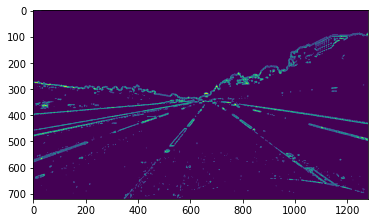

In [6]:
plt.imshow(abs_sobel_thresh(imgs[2],orient='y',thresh_min=30,thresh_max=90))

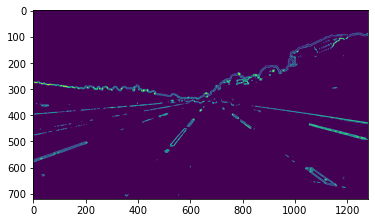

In [7]:
plt.imshow(mag_thresh(imgs[2], sobel_kernel=9, mag_thresh=(50, 100)))

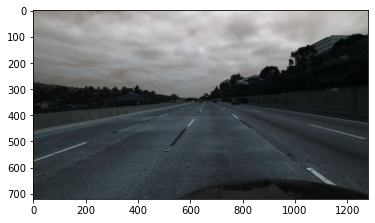

In [8]:
plt.imshow(imgs[2])

In [9]:
def thresholding(img):
    iimg = cv2.GaussianBlur(img,(5,5),0)
    x_thresh = abs_sobel_thresh(img,orient='x',thresh_min=30,thresh_max=100)
    y_thresh = abs_sobel_thresh(img,orient='y',thresh_min=30,thresh_max=90)
    mag_thres = mag_thresh(img, sobel_kernel=9, mag_thresh=(50, 100))
    hls_s_thresh = hls_channels(img,'s',thresh=(170, 255))              
    threshholded = np.zeros_like(x_thresh)
    R = img[:,:,2]
    G = img[:,:,1]
    threshholded[(((x_thresh == 1) & (y_thresh == 1)) & (mag_thres ==1)) | (hls_s_thresh ==1)] = 1

    return threshholded
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, vertices, 255)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

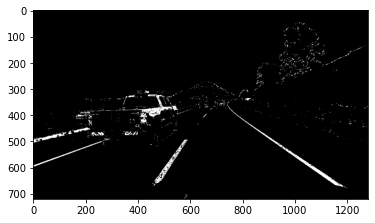

In [22]:
img = imgs[1]
img = thresholding(img)
plt.imshow(img,"gray")

###### 

(720, 1280)


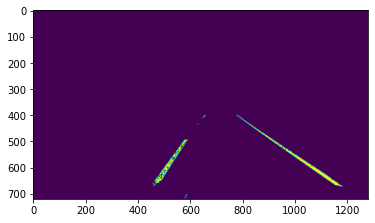

In [23]:
imshape = img.shape
print(imshape)
lower_left = [400,imshape[0]]
lower_right = [1250,imshape[0]]
top_left = [600,400]
top_right = [800,400]
vertices = [np.array([lower_left,top_left,top_right,lower_right],dtype=np.int32)]
roi_image = region_of_interest(img, vertices)
plt.imshow(roi_image)

In [12]:
def get_slope(x1,y1,x2,y2):
    return (y2-y1)/(x2-x1)

In [13]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    # lines = (xstart,ystart,xend,yend) 
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    #print(lines)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img,lines)
    return line_img

In [14]:
def draw_lines(img, lines, color=[255, 0, 0]):
    """workflow:
    1) examine each individual line returned by hough & determine if it's in left or right lane by its slope
    because we are working "upside down" with the array, the left lane will have a negative slope and right positive
    2) track extrema
    3) compute averages
    4) solve for b intercept 
    5) use extrema to solve for points
    6) smooth frames and cache
    """
    global cache
    global first_frame
    y_min = img.shape[0] #min will be the "highest" y value, or point down the road away from car
    y_max = img.shape[0]
    l_slope, r_slope = [],[]
    l_lane,r_lane = [],[]
    det_slope = 0.4
    α =0.2 
    
    for line in lines:
        #1
        for x1,y1,x2,y2 in line:
            slope = get_slope(x1,y1,x2,y2)
            if slope > det_slope:
                r_slope.append(slope)
                r_lane.append(line)
            elif slope < -det_slope:
                l_slope.append(slope)
                l_lane.append(line)
        y_min = min(y1,y2,y_min)
    
    if len(l_lane) == 0:
        print ('left lane not detected')
        return 1
    if len(r_lane) == 0:
        print ('right lane not detected')
        return 1
        
    #3
    l_slope_mean = np.mean(l_slope,axis =0)
    r_slope_mean = np.mean(r_slope,axis =0)
    l_mean = np.mean(np.array(l_lane),axis=0)
    r_mean = np.mean(np.array(r_lane),axis=0)
    
    if ((r_slope_mean == 0) or (l_slope_mean == 0 )):
        print('dividing by zero')
        return 1
    
    #  y=mx+b -> b = y -mx
    l_b = l_mean[0][1] - (l_slope_mean * l_mean[0][0])
    r_b = r_mean[0][1] - (r_slope_mean * r_mean[0][0])
    
    #5, using y-extrema (#2), b intercept (#4), and slope (#3) solve for x using y=mx+b
    # x = (y-b)/m
    # these 4 points are our two lines that we will pass to the draw function
    l_x1 = int((y_min - l_b)/l_slope_mean) 
    l_x2 = int((y_max - l_b)/l_slope_mean)   
    r_x1 = int((y_min - r_b)/r_slope_mean)
    r_x2 = int((y_max - r_b)/r_slope_mean)
    
    #6
    if l_x1 > r_x1:
        l_x1 = int((l_x1+r_x1)/2)
        r_x1 = l_x1
        l_y1 = int((l_slope_mean * l_x1 ) + l_b)
        r_y1 = int((r_slope_mean * r_x1 ) + r_b)
        l_y2 = int((l_slope_mean * l_x2 ) + l_b)
        r_y2 = int((r_slope_mean * r_x2 ) + r_b)
    else:
        l_y1 = y_min
        l_y2 = y_max
        r_y1 = y_min
        r_y2 = y_max
      
    current_frame = np.array([l_x1,l_y1,l_x2,l_y2,r_x1,r_y1,r_x2,r_y2],dtype ="float32")
    
    if first_frame == 1:
        next_frame = current_frame        
        first_frame = 0        
    else :
        prev_frame = cache
        next_frame = (1-α)*prev_frame+α*current_frame
             
    cv2.line(img, (int(next_frame[0]), int(next_frame[1])), (int(next_frame[2]),int(next_frame[3])), color, 10)
    cv2.line(img, (int(next_frame[4]), int(next_frame[5])), (int(next_frame[6]),int(next_frame[7])), color, 10)
    
    cache = next_frame

In [15]:
rho = 4
theta = np.pi/180
#threshold is minimum number of intersections in a grid for candidate line to go to output
threshold = 30
min_line_len = 40
max_line_gap = 180

global first_frame
global cache
first_frame = 1
line_image = hough_lines(roi_image, rho, theta, threshold, min_line_len, max_line_gap)
result = cv2.addWeighted(imgs[121], 0.8, line_image, 1., 0.)

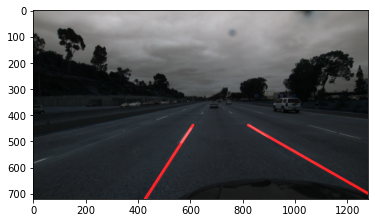

In [16]:
plt.imshow(result)

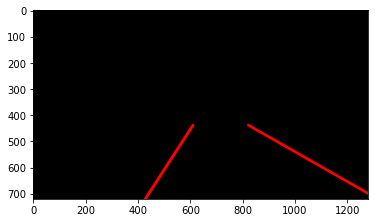

In [17]:
plt.imshow(line_image)

# way 2

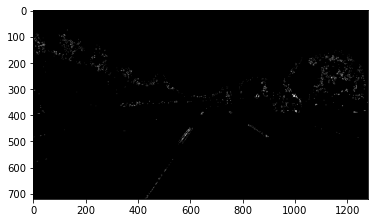

In [18]:
img = imgs[121]
img = thresholding(img)
plt.imshow(img,"gray")

In [19]:
def perspective_transform(img, src, dst, inv=False):
    if inv:
        M = cv2.getPerspectiveTransform(dst, src)    
    else:
        M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    return warped